In [2]:
import os 
os.chdir("..")


In [32]:
%load_ext autoreload
%autoreload 2
from numerics.integration.steps import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numerics.utilities.misc import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
params = give_def_params()
params, exp_path = check_params(params)
[eta, gamma, kappa, omega, n] = params



In [44]:
pars = give_def_params_discrimination(flip=0, mode="frequencies") ## H0 is the true hypothesis
params, exp_path = check_params(pars)

total_time, dt = get_total_time_dt(params, ppp=1e4)

times, logliks, states1, states0, signals, covs1, covs0 =load_data_discrimination(itraj=10, total_time = total_time, dt=dt, exp_path = exp_path)

FREQUENCY DISCRIMINATION!



In [56]:
states1[:,0][:100]

array([ 0.0000000e+00,  1.4927807e-01,  9.7197413e-01, -2.5537089e+05,
        2.4492620e+15, -1.5947105e+37,            inf,            inf,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
      

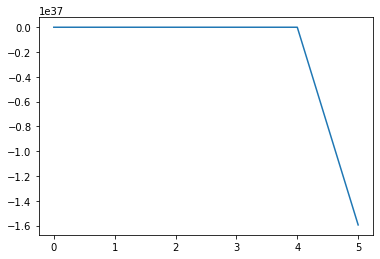

In [53]:
plt.plot(states1[:100,0])

In [19]:
times = load_data(ppp=ppp, periods=periods,method=method, itraj=itraj, exp_path=exp_path , rppp = rppp_reference)


In [28]:
ppp*(times[1]-times[0])/(2*np.pi)

9.999999558922882e-05

In [23]:
times[1:] - times[:-1]

array([6.2831850e-07, 6.2831850e-07, 6.2831862e-07, ..., 6.3329935e-07,
       6.2584877e-07, 6.2584877e-07], dtype=float32)